In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/premiumpulse-risk-modeling/sample_submission.csv
/kaggle/input/premiumpulse-risk-modeling/train.csv
/kaggle/input/premiumpulse-risk-modeling/test.csv


In [2]:
#https://www.kaggle.com/competitions/premiumpulse-risk-modeling/overview

# === MANIPULACIÓN DE DATOS ===
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# === VISUALIZACIÓN ===
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# === PREPROCESAMIENTO ===
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    LabelEncoder, OneHotEncoder, OrdinalEncoder,
    PowerTransformer, QuantileTransformer
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# === DIVISIÓN DE DATOS ===
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_validate,
    StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV,
    validation_curve, learning_curve
)

# === MODELOS DE CLASIFICACIÓN ===
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, AdaBoostClassifier,
    VotingClassifier, BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# === MODELOS DE REGRESIÓN ===
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    SGDRegressor, BayesianRidge, HuberRegressor
)
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, AdaBoostRegressor,
    VotingRegressor, BaggingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# === CLUSTERING ===
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# === REDUCCIÓN DE DIMENSIONALIDAD ===
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.manifold import TSNE
from sklearn.feature_selection import (
    SelectKBest, SelectFromModel, RFE, RFECV,
    chi2, f_classif, f_regression, mutual_info_classif
)

# === MÉTRICAS ===
from sklearn.metrics import (
    # Clasificación
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, auc, log_loss,
 
    # Regresión
    mean_squared_error, mean_absolute_error, r2_score,
    mean_squared_log_error, mean_absolute_percentage_error,
    
    # Clustering
    silhouette_score, adjusted_rand_score, calinski_harabasz_score
)

# === GRADIENT BOOSTING 

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor

# === ANÁLISIS ESTADÍSTICO ===

import scipy.stats as stats
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# === TIME SERIES ===

from prophet import Prophet

# === OPTIMIZACIÓN DE HIPERPARÁMETROS ===

import optuna

# === UTILIDADES ===
import os
import sys
import json
import pickle
import joblib
from datetime import datetime, timedelta
import itertools
from collections import Counter
import gc

# === CONFIGURACIÓN DE PANDAS ===
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.width', None)

# === CONFIGURACIÓN DE MATPLOTLIB ===
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# === CONFIGURACIÓN DE SEABORN ===
sns.set_palette("husl")
sns.set_style("whitegrid")

# === CONFIGURACIÓN DE NUMPY ===
np.random.seed(1722)

In [3]:
train = pd.read_csv('/kaggle/input/premiumpulse-risk-modeling/train.csv')
test = pd.read_csv('/kaggle/input/premiumpulse-risk-modeling/test.csv')

In [4]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0000,Female,10049.0000,Married,1.0000,Bachelor's,Self-Employed,22.5988,Urban,Premium,2.0000,17.0000,372.0000,5.0000,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0000
1,1,39.0000,Female,31678.0000,Divorced,3.0000,Master's,NaN,15.5697,Rural,Comprehensive,1.0000,12.0000,694.0000,2.0000,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0000
2,2,23.0000,Male,25602.0000,Divorced,3.0000,High School,Self-Employed,47.1775,Suburban,Premium,1.0000,14.0000,NaN,3.0000,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0000
3,3,21.0000,Male,141855.0000,Married,2.0000,Bachelor's,NaN,10.9381,Rural,Basic,1.0000,0.0000,367.0000,1.0000,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0000
4,4,21.0000,Male,39651.0000,Single,1.0000,Bachelor's,Self-Employed,20.3761,Rural,Premium,0.0000,8.0000,598.0000,4.0000,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0000


In [5]:
test.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0000,Female,2310.0000,NaN,4.0000,Bachelor's,Self-Employed,7.6580,Rural,Basic,NaN,19.0000,NaN,1.0000,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0000,Female,126031.0000,Married,2.0000,Master's,Self-Employed,13.3814,Suburban,Premium,NaN,14.0000,372.0000,8.0000,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0000,Female,17092.0000,Divorced,0.0000,PhD,Unemployed,24.3545,Urban,Comprehensive,NaN,16.0000,819.0000,9.0000,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0000,Female,30424.0000,Divorced,3.0000,PhD,Self-Employed,5.1362,Suburban,Comprehensive,1.0000,3.0000,770.0000,5.0000,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0000,Male,10863.0000,Divorced,2.0000,High School,Unemployed,11.8442,Suburban,Premium,NaN,14.0000,755.0000,7.0000,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [6]:
#lo primero sera ver como correr rapido un RandomForest y ver como esta la cosa
#variable a predecir "Premium Amount"
#ver si sacar "id" y la agrego al final
#Pasar a logaritmo el "Annual Income" y tal vez el "Credit Score"
#Ver los NaN cuantos son y como proceder
#Variables categoricas:"Marital Status","Location","Property Type"
#Variables categoricas ordinales: "Education Level","Occupation","Policy Type","Customer Feedback","Exercise Frequency"
#Analisis de correlaciones
#separar Policy Start Date en varias columnas año/mes/dia/hora ver si es relevante el dia como lun/mar/mier o por semanas
#ver si las variables numericas parecieran seguir algun tipo de distribucion normal/poisson/uniforme etc..
# Variable "Gender" por un tema de discriminacion la saco o no ? , espero a ver la importancia en un random forest para decidir

In [7]:
train.describe(include="all")

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
count,1200000.0000,1181295.0000,1200000,1155051.0000,1181471,1090328.0000,1200000,841925,1125924.0000,1200000,1200000,835971.0000,1199994.0000,1062118.0000,1199999.0000,1200000,1122176,1200000,1200000,1200000,1200000.0000
unique,NaN,NaN,2,NaN,3,NaN,4,3,NaN,3,3,NaN,NaN,NaN,NaN,167381,3,2,4,3,NaN
top,NaN,NaN,Male,NaN,Single,NaN,Master's,Employed,NaN,Suburban,Premium,NaN,NaN,NaN,NaN,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House,NaN
freq,NaN,NaN,602571,NaN,395391,NaN,303818,282750,NaN,401542,401846,NaN,NaN,NaN,NaN,142,377905,601873,306179,400349,NaN
mean,599999.5000,41.1456,NaN,32745.2178,NaN,2.0099,NaN,NaN,25.6139,NaN,NaN,1.0027,9.5699,592.9244,5.0182,NaN,NaN,NaN,NaN,NaN,1102.5448
std,346410.3059,13.5399,NaN,32179.5061,NaN,1.4173,NaN,NaN,12.2035,NaN,NaN,0.9828,5.7762,149.9819,2.5943,NaN,NaN,NaN,NaN,NaN,864.9989
min,0.0000,18.0000,NaN,1.0000,NaN,0.0000,NaN,NaN,2.0122,NaN,NaN,0.0000,0.0000,300.0000,1.0000,NaN,NaN,NaN,NaN,NaN,20.0000
25%,299999.7500,30.0000,NaN,8001.0000,NaN,1.0000,NaN,NaN,15.9190,NaN,NaN,0.0000,5.0000,468.0000,3.0000,NaN,NaN,NaN,NaN,NaN,514.0000
50%,599999.5000,41.0000,NaN,23911.0000,NaN,2.0000,NaN,NaN,24.5786,NaN,NaN,1.0000,10.0000,595.0000,5.0000,NaN,NaN,NaN,NaN,NaN,872.0000
75%,899999.2500,53.0000,NaN,44634.0000,NaN,3.0000,NaN,NaN,34.5272,NaN,NaN,2.0000,15.0000,721.0000,7.0000,NaN,NaN,NaN,NaN,NaN,1509.0000


In [8]:
test.describe(include="all")# los valores entre test y train parecieran salir de una misma poblacion por como estan distribuidos , parece sintetico/ficticio

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,800000.0000,787511.0000,800000,770140.0000,787664,726870.0000,800000,560875,750551.0000,800000,800000,557198.0000,799997.0000,708549.0000,799998.0000,800000,747724,800000,800000,800000
unique,NaN,NaN,2,NaN,3,NaN,4,3,NaN,3,3,NaN,NaN,NaN,NaN,158776,3,2,4,3
top,NaN,NaN,Male,NaN,Single,NaN,Master's,Employed,NaN,Suburban,Premium,NaN,NaN,NaN,NaN,2022-08-30 15:21:39.134960,Average,Yes,Weekly,House
freq,NaN,NaN,401089,NaN,263705,NaN,202552,188574,NaN,267190,267629,NaN,NaN,NaN,NaN,98,251217,401859,204514,267151
mean,1599999.5000,41.1364,NaN,32803.8715,NaN,2.0093,NaN,NaN,25.6130,NaN,NaN,1.0049,9.5719,592.9047,5.0189,NaN,NaN,NaN,NaN,NaN
std,230940.2520,13.5378,NaN,32201.0637,NaN,1.4152,NaN,NaN,12.2069,NaN,NaN,0.9828,5.7722,150.1164,2.5938,NaN,NaN,NaN,NaN,NaN
min,1200000.0000,18.0000,NaN,2.0000,NaN,0.0000,NaN,NaN,1.6466,NaN,NaN,0.0000,0.0000,300.0000,1.0000,NaN,NaN,NaN,NaN,NaN
25%,1399999.7500,30.0000,NaN,8048.0000,NaN,1.0000,NaN,NaN,15.9174,NaN,NaN,0.0000,5.0000,468.0000,3.0000,NaN,NaN,NaN,NaN,NaN
50%,1599999.5000,41.0000,NaN,23981.0000,NaN,2.0000,NaN,NaN,24.5802,NaN,NaN,1.0000,10.0000,595.0000,5.0000,NaN,NaN,NaN,NaN,NaN
75%,1799999.2500,53.0000,NaN,44660.0000,NaN,3.0000,NaN,NaN,34.5178,NaN,NaN,2.0000,15.0000,721.0000,7.0000,NaN,NaN,NaN,NaN,NaN


In [9]:
#train.isnull().sum()
#train["Age"].value_counts() parece seguir una distribucion uniforme entre 18 a 64 años ,
# voy a reemplazar los NaN en la edad con la mediana , pero voy a crear una columna binaria para que el modelo sepa si habia NaN en la Edad
# es por si en esas edad en particular el cambio que hice perjudica al modelo , ya sea porque asigne mas riesgo a esa edad o saque conclusiones
# que no son correctas debido a mi manipulacion y el hecho de que hace ruido que la edad este distribuida uniformemente entre todos los rangos

train1 = train.copy()
test1 = test.copy()

train1["Age_NaN"] = train["Age"].isna().astype(int)
test1["Age_NaN"] = test["Age"].isna().astype(int)


train1["Age"] = train["Age"].fillna(train["Age"].median())

#train["Age"].value_counts()

test1["Age"] = test["Age"].fillna(test["Age"].median())

#test1["Age"].value_counts()

train1["Age_NaN"] = train["Age"].isna().astype(int)
test1["Age_NaN"] = test["Age"].isna().astype(int)

#train1.head(10)
#test1.head(10)

In [10]:
#train1.head(10)
train1["Age_NaN"].value_counts()
#test1["Age_NaN"].value_counts()

Age_NaN
0    1181295
1      18705
Name: count, dtype: int64

In [11]:
train1["An_Income_NaN"] = train["Annual Income"].isna().astype(int)
test1["An_Income_NaN"] = test["Annual Income"].isna().astype(int)


train1["Annual Income"] = train["Annual Income"].fillna(train["Annual Income"].median())
test1["Annual Income"] = test["Annual Income"].fillna(test["Annual Income"].median())


train1["Log Annual Income"] = np.log(train1["Annual Income"])
test1["Log Annual Income"] = np.log(test1["Annual Income"])

train1 = train1.drop("Annual Income", axis = 1)
test1 = test1.drop("Annual Income", axis = 1)

In [12]:
#train1.head(10)
train1["An_Income_NaN"].value_counts()
test1["An_Income_NaN"].value_counts()

An_Income_NaN
0    770140
1     29860
Name: count, dtype: int64

In [13]:
train1.head()

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income
0,0,19.0000,Female,Married,1.0000,Bachelor's,Self-Employed,22.5988,Urban,Premium,2.0000,17.0000,372.0000,5.0000,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0000,0,0,9.2152
1,1,39.0000,Female,Divorced,3.0000,Master's,NaN,15.5697,Rural,Comprehensive,1.0000,12.0000,694.0000,2.0000,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0000,0,0,10.3634
2,2,23.0000,Male,Divorced,3.0000,High School,Self-Employed,47.1775,Suburban,Premium,1.0000,14.0000,NaN,3.0000,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0000,0,0,10.1504
3,3,21.0000,Male,Married,2.0000,Bachelor's,NaN,10.9381,Rural,Basic,1.0000,0.0000,367.0000,1.0000,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0000,0,0,11.8626
4,4,21.0000,Male,Single,1.0000,Bachelor's,Self-Employed,20.3761,Rural,Premium,0.0000,8.0000,598.0000,4.0000,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0000,0,0,10.5879


In [14]:
#para el "Credit Score" le hago categorias , uso Ordinal Scoring

def categorize_Credit_Score(score):
    if pd.isna(score):
        return 'X'  # Sin historial
    elif score >= 800:
        return 'A'  # Excepcional (800-850)
    elif score >= 750:
        return 'B'  # Muy Bueno
    elif score >= 700:
        return 'C'  # Bueno
    elif score >= 650:
        return 'D'  # Regular+
    elif score >= 600:
        return 'E'  # Regular
    elif score >= 550:
        return 'F'  # Malo+
    elif score >= 500:
        return 'G'  # Malo
    elif score >= 400:
        return 'H'  # Muy Malo
    else:  # 300-399
        return 'I'  # Pésimo

train1['Credit_Grade'] = train1['Credit Score'].apply(categorize_Credit_Score)
test1['Credit_Grade'] = test1['Credit Score'].apply(categorize_Credit_Score)


grade_map = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'H':2, 'I':1, 'X':0}
train1['Credit Score'] = train1['Credit_Grade'].map(grade_map)
test1['Credit Score'] = test1['Credit_Grade'].map(grade_map)

In [15]:
train1.head()

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Credit_Grade
0,0,19.0000,Female,Married,1.0000,Bachelor's,Self-Employed,22.5988,Urban,Premium,2.0000,17.0000,1,5.0000,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0000,0,0,9.2152,I
1,1,39.0000,Female,Divorced,3.0000,Master's,NaN,15.5697,Rural,Comprehensive,1.0000,12.0000,6,2.0000,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0000,0,0,10.3634,D
2,2,23.0000,Male,Divorced,3.0000,High School,Self-Employed,47.1775,Suburban,Premium,1.0000,14.0000,0,3.0000,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0000,0,0,10.1504,X
3,3,21.0000,Male,Married,2.0000,Bachelor's,NaN,10.9381,Rural,Basic,1.0000,0.0000,1,1.0000,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0000,0,0,11.8626,I
4,4,21.0000,Male,Single,1.0000,Bachelor's,Self-Employed,20.3761,Rural,Premium,0.0000,8.0000,4,4.0000,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0000,0,0,10.5879,F


In [16]:
train1 = train1.drop("Credit_Grade", axis = 1)
test1 = test1.drop("Credit_Grade", axis = 1)

test1.head()

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Age_NaN,An_Income_NaN,Log Annual Income
0,1200000,28.0000,Female,NaN,4.0000,Bachelor's,Self-Employed,7.6580,Rural,Basic,NaN,19.0000,0,1.0000,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House,0,0,7.7450
1,1200001,31.0000,Female,Married,2.0000,Master's,Self-Employed,13.3814,Suburban,Premium,NaN,14.0000,1,8.0000,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment,0,0,11.7443
2,1200002,47.0000,Female,Divorced,0.0000,PhD,Unemployed,24.3545,Urban,Comprehensive,NaN,16.0000,9,9.0000,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo,0,0,9.7464
3,1200003,28.0000,Female,Divorced,3.0000,PhD,Self-Employed,5.1362,Suburban,Comprehensive,1.0000,3.0000,8,5.0000,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House,0,0,10.3230
4,1200004,24.0000,Male,Divorced,2.0000,High School,Unemployed,11.8442,Suburban,Premium,NaN,14.0000,8,7.0000,2021-11-26 15:21:39.259788,Average,No,Weekly,House,0,0,9.2931


In [17]:
train2 = train1.copy()
test2 = test1.copy()

In [18]:
#Reemplazo NaN por Unknown

train2['Marital Status'] = train2['Marital Status'].fillna('Unknown')
test2['Marital Status'] = test2['Marital Status'].fillna('Unknown')

train2.describe(include="all")

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income
count,1200000.0000,1200000.0000,1200000,1200000,1090328.0000,1200000,841925,1125924.0000,1200000,1200000,835971.0000,1199994.0000,1200000.0000,1199999.0000,1200000,1122176,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1200000.0000
unique,NaN,NaN,2,4,NaN,4,3,NaN,3,3,NaN,NaN,NaN,NaN,167381,3,2,4,3,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,Single,NaN,Master's,Employed,NaN,Suburban,Premium,NaN,NaN,NaN,NaN,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House,NaN,NaN,NaN,NaN
freq,NaN,NaN,602571,395391,NaN,303818,282750,NaN,401542,401846,NaN,NaN,NaN,NaN,142,377905,601873,306179,400349,NaN,NaN,NaN,NaN
mean,599999.5000,41.1433,NaN,NaN,2.0099,NaN,NaN,25.6139,NaN,NaN,1.0027,9.5699,4.0886,5.0182,NaN,NaN,NaN,NaN,NaN,1102.5448,0.0156,0.0375,9.7790
std,346410.3059,13.4340,NaN,NaN,1.4173,NaN,NaN,12.2035,NaN,NaN,0.9828,5.7762,2.8712,2.5943,NaN,NaN,NaN,NaN,NaN,864.9989,0.1239,0.1899,1.3301
min,0.0000,18.0000,NaN,NaN,0.0000,NaN,NaN,2.0122,NaN,NaN,0.0000,0.0000,0.0000,1.0000,NaN,NaN,NaN,NaN,NaN,20.0000,0.0000,0.0000,0.0000
25%,299999.7500,30.0000,NaN,NaN,1.0000,NaN,NaN,15.9190,NaN,NaN,0.0000,5.0000,2.0000,3.0000,NaN,NaN,NaN,NaN,NaN,514.0000,0.0000,0.0000,9.0649
50%,599999.5000,41.0000,NaN,NaN,2.0000,NaN,NaN,24.5786,NaN,NaN,1.0000,10.0000,4.0000,5.0000,NaN,NaN,NaN,NaN,NaN,872.0000,0.0000,0.0000,10.0821
75%,899999.2500,53.0000,NaN,NaN,3.0000,NaN,NaN,34.5272,NaN,NaN,2.0000,15.0000,7.0000,7.0000,NaN,NaN,NaN,NaN,NaN,1509.0000,0.0000,0.0000,10.6905


count   1090328.0000
mean          2.0099
std           1.4173
min           0.0000
25%           1.0000
50%           2.0000
75%           3.0000
max           4.0000
Name: Number of Dependents, dtype: float64


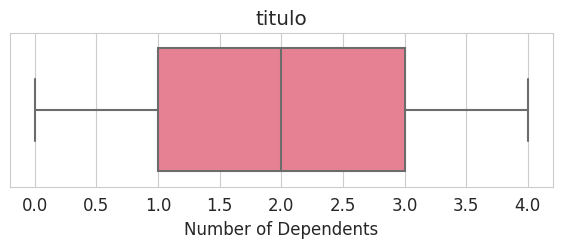

In [19]:
plt.figure(figsize=(7,2)) 
plt.title("titulo")
sns.boxplot(x=train2["Number of Dependents"])
print(train2["Number of Dependents"].describe())

<Axes: title={'center': 'Number of Dependents'}, xlabel='Number of Dependents', ylabel='Count'>

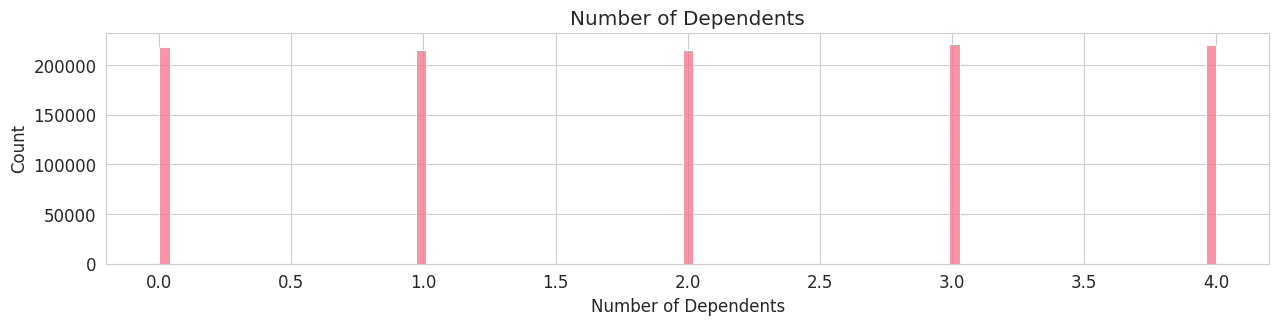

In [20]:
plt.figure(figsize=(15,3)) 
plt.title("Number of Dependents")
sns.histplot(train2["Number of Dependents"]) 

In [21]:
#para 'Number of Dependents' voy a poner -1 en los NaN y crear una columna que lo aclare

train2['Number of Dependents'] = train2['Number of Dependents'].fillna(-1)
test2['Number of Dependents'] = test2['Number of Dependents'].fillna(-1)


train2['Dependents_NaN'] = (train2['Number of Dependents'] == -1).astype(int)
test2['Dependents_NaN'] = (test2['Number of Dependents'] == -1).astype(int)


In [22]:
#test2.head()
train2['Dependents_NaN'].value_counts()

Dependents_NaN
0    1090328
1     109672
Name: count, dtype: int64

In [23]:
train2.describe(include="all")

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN
count,1200000.0000,1200000.0000,1200000,1200000,1200000.0000,1200000,841925,1125924.0000,1200000,1200000,835971.0000,1199994.0000,1200000.0000,1199999.0000,1200000,1122176,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000
unique,NaN,NaN,2,4,NaN,4,3,NaN,3,3,NaN,NaN,NaN,NaN,167381,3,2,4,3,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,Single,NaN,Master's,Employed,NaN,Suburban,Premium,NaN,NaN,NaN,NaN,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,602571,395391,NaN,303818,282750,NaN,401542,401846,NaN,NaN,NaN,NaN,142,377905,601873,306179,400349,NaN,NaN,NaN,NaN,NaN
mean,599999.5000,41.1433,NaN,NaN,1.7348,NaN,NaN,25.6139,NaN,NaN,1.0027,9.5699,4.0886,5.0182,NaN,NaN,NaN,NaN,NaN,1102.5448,0.0156,0.0375,9.7790,0.0914
std,346410.3059,13.4340,NaN,NaN,1.6055,NaN,NaN,12.2035,NaN,NaN,0.9828,5.7762,2.8712,2.5943,NaN,NaN,NaN,NaN,NaN,864.9989,0.1239,0.1899,1.3301,0.2882
min,0.0000,18.0000,NaN,NaN,-1.0000,NaN,NaN,2.0122,NaN,NaN,0.0000,0.0000,0.0000,1.0000,NaN,NaN,NaN,NaN,NaN,20.0000,0.0000,0.0000,0.0000,0.0000
25%,299999.7500,30.0000,NaN,NaN,0.0000,NaN,NaN,15.9190,NaN,NaN,0.0000,5.0000,2.0000,3.0000,NaN,NaN,NaN,NaN,NaN,514.0000,0.0000,0.0000,9.0649,0.0000
50%,599999.5000,41.0000,NaN,NaN,2.0000,NaN,NaN,24.5786,NaN,NaN,1.0000,10.0000,4.0000,5.0000,NaN,NaN,NaN,NaN,NaN,872.0000,0.0000,0.0000,10.0821,0.0000
75%,899999.2500,53.0000,NaN,NaN,3.0000,NaN,NaN,34.5272,NaN,NaN,2.0000,15.0000,7.0000,7.0000,NaN,NaN,NaN,NaN,NaN,1509.0000,0.0000,0.0000,10.6905,0.0000


In [24]:
# para Occupation reemplazo NaN por Unknown

train2['Occupation'] = train2['Occupation'].fillna('Unknown')
test2['Occupation'] = test2['Occupation'].fillna('Unknown')

test2.describe(include="all")

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN
count,800000.0000,800000.0000,800000,800000,800000.0000,800000,800000,750551.0000,800000,800000,557198.0000,799997.0000,800000.0000,799998.0000,800000,747724,800000,800000,800000,800000.0000,800000.0000,800000.0000,800000.0000
unique,NaN,NaN,2,4,NaN,4,4,NaN,3,3,NaN,NaN,NaN,NaN,158776,3,2,4,3,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,Single,NaN,Master's,Unknown,NaN,Suburban,Premium,NaN,NaN,NaN,NaN,2022-08-30 15:21:39.134960,Average,Yes,Weekly,House,NaN,NaN,NaN,NaN
freq,NaN,NaN,401089,263705,NaN,202552,239125,NaN,267190,267629,NaN,NaN,NaN,NaN,98,251217,401859,204514,267151,NaN,NaN,NaN,NaN
mean,1599999.5000,41.1343,NaN,NaN,1.7342,NaN,NaN,25.6130,NaN,NaN,1.0049,9.5719,4.0915,5.0189,NaN,NaN,NaN,NaN,NaN,0.0156,0.0373,9.7808,0.0914
std,230940.2520,13.4318,NaN,NaN,1.6037,NaN,NaN,12.2069,NaN,NaN,0.9828,5.7722,2.8721,2.5938,NaN,NaN,NaN,NaN,NaN,0.1240,0.1896,1.3303,0.2882
min,1200000.0000,18.0000,NaN,NaN,-1.0000,NaN,NaN,1.6466,NaN,NaN,0.0000,0.0000,0.0000,1.0000,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.6931,0.0000
25%,1399999.7500,30.0000,NaN,NaN,0.0000,NaN,NaN,15.9174,NaN,NaN,0.0000,5.0000,2.0000,3.0000,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,9.0698,0.0000
50%,1599999.5000,41.0000,NaN,NaN,2.0000,NaN,NaN,24.5802,NaN,NaN,1.0000,10.0000,4.0000,5.0000,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,10.0850,0.0000
75%,1799999.2500,53.0000,NaN,NaN,3.0000,NaN,NaN,34.5178,NaN,NaN,2.0000,15.0000,7.0000,7.0000,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,10.6907,0.0000


In [25]:
train2.describe(include="all")

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN
count,1200000.0000,1200000.0000,1200000,1200000,1200000.0000,1200000,1200000,1125924.0000,1200000,1200000,835971.0000,1199994.0000,1200000.0000,1199999.0000,1200000,1122176,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000
unique,NaN,NaN,2,4,NaN,4,4,NaN,3,3,NaN,NaN,NaN,NaN,167381,3,2,4,3,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,Single,NaN,Master's,Unknown,NaN,Suburban,Premium,NaN,NaN,NaN,NaN,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,602571,395391,NaN,303818,358075,NaN,401542,401846,NaN,NaN,NaN,NaN,142,377905,601873,306179,400349,NaN,NaN,NaN,NaN,NaN
mean,599999.5000,41.1433,NaN,NaN,1.7348,NaN,NaN,25.6139,NaN,NaN,1.0027,9.5699,4.0886,5.0182,NaN,NaN,NaN,NaN,NaN,1102.5448,0.0156,0.0375,9.7790,0.0914
std,346410.3059,13.4340,NaN,NaN,1.6055,NaN,NaN,12.2035,NaN,NaN,0.9828,5.7762,2.8712,2.5943,NaN,NaN,NaN,NaN,NaN,864.9989,0.1239,0.1899,1.3301,0.2882
min,0.0000,18.0000,NaN,NaN,-1.0000,NaN,NaN,2.0122,NaN,NaN,0.0000,0.0000,0.0000,1.0000,NaN,NaN,NaN,NaN,NaN,20.0000,0.0000,0.0000,0.0000,0.0000
25%,299999.7500,30.0000,NaN,NaN,0.0000,NaN,NaN,15.9190,NaN,NaN,0.0000,5.0000,2.0000,3.0000,NaN,NaN,NaN,NaN,NaN,514.0000,0.0000,0.0000,9.0649,0.0000
50%,599999.5000,41.0000,NaN,NaN,2.0000,NaN,NaN,24.5786,NaN,NaN,1.0000,10.0000,4.0000,5.0000,NaN,NaN,NaN,NaN,NaN,872.0000,0.0000,0.0000,10.0821,0.0000
75%,899999.2500,53.0000,NaN,NaN,3.0000,NaN,NaN,34.5272,NaN,NaN,2.0000,15.0000,7.0000,7.0000,NaN,NaN,NaN,NaN,NaN,1509.0000,0.0000,0.0000,10.6905,0.0000


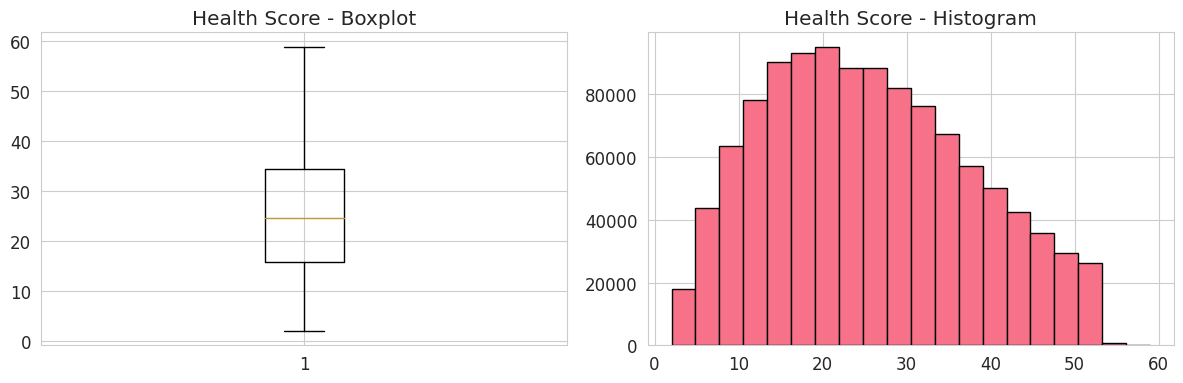

count   1125924.0000
mean         25.6139
std          12.2035
min           2.0122
25%          15.9190
50%          24.5786
75%          34.5272
max          58.9759
Name: Health Score, dtype: float64
NaN: 74076


In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot
ax1.boxplot(train2['Health Score'].dropna())
ax1.set_title('Health Score - Boxplot')

# Histograma
ax2.hist(train2['Health Score'].dropna(), bins=20, edgecolor='black')
ax2.set_title('Health Score - Histogram')

plt.tight_layout()
plt.show()

print(train2['Health Score'].describe())
print(f"NaN: {train2['Health Score'].isna().sum()}")

In [27]:
#Crear rangos y columna nueva para los NaN

# Binning
train2['Health_Score_Binned'] = pd.cut(train2['Health Score'], bins=8, labels=range(8)).astype(float)
train2['Health_Score_Binned'] = train2['Health_Score_Binned'].fillna(-1)
test2['Health_Score_Binned'] = pd.cut(test2['Health Score'], bins=8, labels=range(8)).astype(float)
test2['Health_Score_Binned'] = test2['Health_Score_Binned'].fillna(-1)


# Indicator
train2['Health_NaN'] = (train2['Health_Score_Binned'] == -1).astype(int)
test2['Health_NaN'] = (test2['Health_Score_Binned'] == -1).astype(int)

train2 = train2.drop("Health Score", axis = 1)
test2 = test2.drop("Health Score", axis = 1)


train2.head()

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN,Health_Score_Binned,Health_NaN
0,0,19.0000,Female,Married,1.0000,Bachelor's,Self-Employed,Urban,Premium,2.0000,17.0000,1,5.0000,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0000,0,0,9.2152,0,2.0000,0
1,1,39.0000,Female,Divorced,3.0000,Master's,Unknown,Rural,Comprehensive,1.0000,12.0000,6,2.0000,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0000,0,0,10.3634,0,1.0000,0
2,2,23.0000,Male,Divorced,3.0000,High School,Self-Employed,Suburban,Premium,1.0000,14.0000,0,3.0000,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0000,0,0,10.1504,0,6.0000,0
3,3,21.0000,Male,Married,2.0000,Bachelor's,Unknown,Rural,Basic,1.0000,0.0000,1,1.0000,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0000,0,0,11.8626,0,1.0000,0
4,4,21.0000,Male,Single,1.0000,Bachelor's,Self-Employed,Rural,Premium,0.0000,8.0000,4,4.0000,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0000,0,0,10.5879,0,2.0000,0


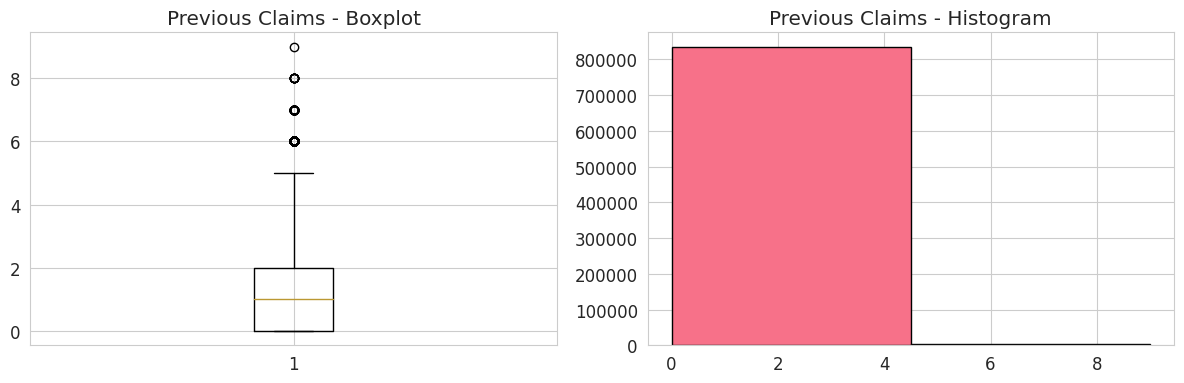

count   835971.0000
mean         1.0027
std          0.9828
min          0.0000
25%          0.0000
50%          1.0000
75%          2.0000
max          9.0000
Name: Previous Claims, dtype: float64
NaN: 364029


In [28]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot
ax1.boxplot(train2['Previous Claims'].dropna())
ax1.set_title('Previous Claims - Boxplot')

# Histograma
ax2.hist(train2['Previous Claims'].dropna(), bins=2, edgecolor='black')
ax2.set_title('Previous Claims - Histogram')

plt.tight_layout()
plt.show()

print(train2['Previous Claims'].describe())
print(f"NaN: {train2['Previous Claims'].isna().sum()}")



In [29]:
#Previous Claim parece una poisson , aplico -1 en los NaN que son bastantes y agrego Columna NaN binaria

train2['Previous Claims'] = train2['Previous Claims'].fillna(-1)
test2['Previous Claims'] = test2['Previous Claims'].fillna(-1)


train2['Previous_Claims_NaN'] = (train2['Previous Claims'] == -1).astype(int)
test2['Previous_Claims_NaN'] = (test2['Previous Claims'] == -1).astype(int)

train2.head()

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN,Health_Score_Binned,Health_NaN,Previous_Claims_NaN
0,0,19.0000,Female,Married,1.0000,Bachelor's,Self-Employed,Urban,Premium,2.0000,17.0000,1,5.0000,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0000,0,0,9.2152,0,2.0000,0,0
1,1,39.0000,Female,Divorced,3.0000,Master's,Unknown,Rural,Comprehensive,1.0000,12.0000,6,2.0000,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0000,0,0,10.3634,0,1.0000,0,0
2,2,23.0000,Male,Divorced,3.0000,High School,Self-Employed,Suburban,Premium,1.0000,14.0000,0,3.0000,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0000,0,0,10.1504,0,6.0000,0,0
3,3,21.0000,Male,Married,2.0000,Bachelor's,Unknown,Rural,Basic,1.0000,0.0000,1,1.0000,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0000,0,0,11.8626,0,1.0000,0,0
4,4,21.0000,Male,Single,1.0000,Bachelor's,Self-Employed,Rural,Premium,0.0000,8.0000,4,4.0000,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0000,0,0,10.5879,0,2.0000,0,0


In [30]:
train3 = train2.copy()
test3 = test2.copy()

train3.describe(include = "all")

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN,Health_Score_Binned,Health_NaN,Previous_Claims_NaN
count,1200000.0000,1200000.0000,1200000,1200000,1200000.0000,1200000,1200000,1200000,1200000,1200000.0000,1199994.0000,1200000.0000,1199999.0000,1200000,1122176,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000
unique,NaN,NaN,2,4,NaN,4,4,3,3,NaN,NaN,NaN,NaN,167381,3,2,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,Single,NaN,Master's,Unknown,Suburban,Premium,NaN,NaN,NaN,NaN,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,602571,395391,NaN,303818,358075,401542,401846,NaN,NaN,NaN,NaN,142,377905,601873,306179,400349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,599999.5000,41.1433,NaN,NaN,1.7348,NaN,NaN,NaN,NaN,0.3952,9.5699,4.0886,5.0182,NaN,NaN,NaN,NaN,NaN,1102.5448,0.0156,0.0375,9.7790,0.0914,2.5746,0.0617,0.3034
std,346410.3059,13.4340,NaN,NaN,1.6055,NaN,NaN,NaN,NaN,1.2331,5.7762,2.8712,2.5943,NaN,NaN,NaN,NaN,NaN,864.9989,0.1239,0.1899,1.3301,0.2882,1.9154,0.2407,0.4597
min,0.0000,18.0000,NaN,NaN,-1.0000,NaN,NaN,NaN,NaN,-1.0000,0.0000,0.0000,1.0000,NaN,NaN,NaN,NaN,NaN,20.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,0.0000,0.0000
25%,299999.7500,30.0000,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,-1.0000,5.0000,2.0000,3.0000,NaN,NaN,NaN,NaN,NaN,514.0000,0.0000,0.0000,9.0649,0.0000,1.0000,0.0000,0.0000
50%,599999.5000,41.0000,NaN,NaN,2.0000,NaN,NaN,NaN,NaN,0.0000,10.0000,4.0000,5.0000,NaN,NaN,NaN,NaN,NaN,872.0000,0.0000,0.0000,10.0821,0.0000,2.0000,0.0000,0.0000
75%,899999.2500,53.0000,NaN,NaN,3.0000,NaN,NaN,NaN,NaN,1.0000,15.0000,7.0000,7.0000,NaN,NaN,NaN,NaN,NaN,1509.0000,0.0000,0.0000,10.6905,0.0000,4.0000,0.0000,1.0000


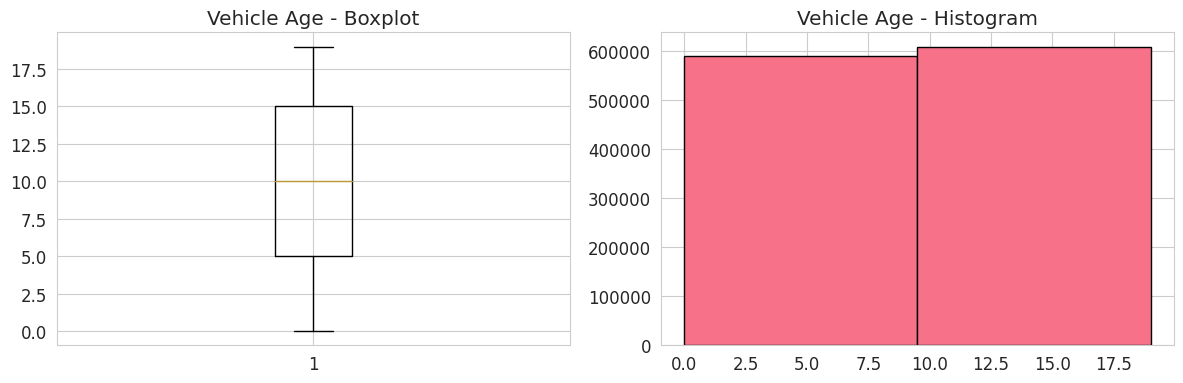

count   1199994.0000
mean          9.5699
std           5.7762
min           0.0000
25%           5.0000
50%          10.0000
75%          15.0000
max          19.0000
Name: Vehicle Age, dtype: float64
NaN: 6


In [31]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot
ax1.boxplot(train3['Vehicle Age'].dropna())
ax1.set_title('Vehicle Age - Boxplot')

# Histograma
ax2.hist(train3['Vehicle Age'].dropna(), bins=2, edgecolor='black')
ax2.set_title('Vehicle Age - Histogram')

plt.tight_layout()
plt.show()

print(train3['Vehicle Age'].describe())
print(f"NaN: {train3['Vehicle Age'].isna().sum()}")

In [32]:
# por solo 6 valores faltantes podria hacer lo que quiera , ya sea eliminar las filas , reemplazar por la media o mediana , etc
# elijo reemplazar por la mediana para conservar 1,2kk de datos

train3['Vehicle Age'] = train3['Vehicle Age'].fillna(train3["Vehicle Age"].median())
test3['Vehicle Age'] = test3['Vehicle Age'].fillna(test3["Vehicle Age"].median())







In [33]:
train3.describe(include="all")

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN,Health_Score_Binned,Health_NaN,Previous_Claims_NaN
count,1200000.0000,1200000.0000,1200000,1200000,1200000.0000,1200000,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1199999.0000,1200000,1122176,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000
unique,NaN,NaN,2,4,NaN,4,4,3,3,NaN,NaN,NaN,NaN,167381,3,2,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,Single,NaN,Master's,Unknown,Suburban,Premium,NaN,NaN,NaN,NaN,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,602571,395391,NaN,303818,358075,401542,401846,NaN,NaN,NaN,NaN,142,377905,601873,306179,400349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,599999.5000,41.1433,NaN,NaN,1.7348,NaN,NaN,NaN,NaN,0.3952,9.5699,4.0886,5.0182,NaN,NaN,NaN,NaN,NaN,1102.5448,0.0156,0.0375,9.7790,0.0914,2.5746,0.0617,0.3034
std,346410.3059,13.4340,NaN,NaN,1.6055,NaN,NaN,NaN,NaN,1.2331,5.7762,2.8712,2.5943,NaN,NaN,NaN,NaN,NaN,864.9989,0.1239,0.1899,1.3301,0.2882,1.9154,0.2407,0.4597
min,0.0000,18.0000,NaN,NaN,-1.0000,NaN,NaN,NaN,NaN,-1.0000,0.0000,0.0000,1.0000,NaN,NaN,NaN,NaN,NaN,20.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,0.0000,0.0000
25%,299999.7500,30.0000,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,-1.0000,5.0000,2.0000,3.0000,NaN,NaN,NaN,NaN,NaN,514.0000,0.0000,0.0000,9.0649,0.0000,1.0000,0.0000,0.0000
50%,599999.5000,41.0000,NaN,NaN,2.0000,NaN,NaN,NaN,NaN,0.0000,10.0000,4.0000,5.0000,NaN,NaN,NaN,NaN,NaN,872.0000,0.0000,0.0000,10.0821,0.0000,2.0000,0.0000,0.0000
75%,899999.2500,53.0000,NaN,NaN,3.0000,NaN,NaN,NaN,NaN,1.0000,15.0000,7.0000,7.0000,NaN,NaN,NaN,NaN,NaN,1509.0000,0.0000,0.0000,10.6905,0.0000,4.0000,0.0000,1.0000


In [34]:
#insurance 1 solo valor , al ser alguien de 64 años osea la edad maxima , le pongo 1 de duration , porque en el dataset no se ve a nadie 
#con una edad superior con poliza activa

nan_row = train3[train3['Insurance Duration'].isna()]
print(nan_row)

train3['Insurance Duration'] = train3['Insurance Duration'].fillna(1)


            id     Age Gender Marital Status  Number of Dependents  \
711358  711358 64.0000   Male        Married                3.0000   

       Education Level Occupation  Location Policy Type  Previous Claims  \
711358        Master's   Employed  Suburban       Basic           0.0000   

        Vehicle Age  Credit Score  Insurance Duration  \
711358      18.0000             4                 NaN   

                 Policy Start Date Customer Feedback Smoking Status  \
711358  2022-04-06 15:21:39.203442              Poor            Yes   

       Exercise Frequency Property Type  Premium Amount  Age_NaN  \
711358             Rarely     Apartment       1044.0000        0   

        An_Income_NaN  Log Annual Income  Dependents_NaN  Health_Score_Binned  \
711358              0            10.3158               0               6.0000   

        Health_NaN  Previous_Claims_NaN  
711358           0                    0  


In [35]:
# son 2 casos distintos , pero 2 datos entre 800k no me va a cambiar ,asi que tambien pongo 1 

nan_row = test3[test3['Insurance Duration'].isna()]
print(nan_row)

test3['Insurance Duration'] = test3['Insurance Duration'].fillna(1)

             id     Age Gender Marital Status  Number of Dependents  \
627445  1827445 53.0000   Male        Married                3.0000   
706315  1906315 23.0000   Male         Single                1.0000   

       Education Level Occupation Location Policy Type  Previous Claims  \
627445        Master's    Unknown    Rural       Basic          -1.0000   
706315        Master's    Unknown    Urban       Basic           2.0000   

        Vehicle Age  Credit Score  Insurance Duration  \
627445       0.0000             6                 NaN   
706315      14.0000             2                 NaN   

                 Policy Start Date Customer Feedback Smoking Status  \
627445  2023-02-10 15:21:39.199447              Poor             No   
706315  2020-01-25 15:21:39.223390              Poor             No   

       Exercise Frequency Property Type  Age_NaN  An_Income_NaN  \
627445             Weekly         House        0              0   
706315            Monthly     Apartment 

In [36]:
# para Policy Start date extraigo  AÑO/TRIMESTRE/MES/DIA/ DIA SEMANA  hora/minutos/segundos puede ser ruido , capaz las horas por querer ver
# el horario laboral de cuando se hacen mas inicio de poliza
# luego elimino la fecha

# Convertir a datetime si no lo está
train3['Policy Start Date'] = pd.to_datetime(train3['Policy Start Date'])
test3['Policy Start Date'] = pd.to_datetime(test3['Policy Start Date'])


train3['Year'] = train3['Policy Start Date'].dt.year
train3['Quarter'] = train3['Policy Start Date'].dt.quarter
train3['Month'] = train3['Policy Start Date'].dt.month
train3['Day'] = train3['Policy Start Date'].dt.day
train3['DayOfWeek'] = train3['Policy Start Date'].dt.dayofweek  # 0=Lunes, 6=Domingo
train3['Hour'] = train3['Policy Start Date'].dt.hour

test3['Year'] = test3['Policy Start Date'].dt.year
test3['Quarter'] = test3['Policy Start Date'].dt.quarter
test3['Month'] = test3['Policy Start Date'].dt.month
test3['Day'] = test3['Policy Start Date'].dt.day
test3['DayOfWeek'] = test3['Policy Start Date'].dt.dayofweek
test3['Hour'] = test3['Policy Start Date'].dt.hour

In [37]:
train3 = train3.drop('Policy Start Date', axis=1)
test3 = test3.drop('Policy Start Date', axis=1)


train3.head()

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN,Health_Score_Binned,Health_NaN,Previous_Claims_NaN,Year,Quarter,Month,Day,DayOfWeek,Hour
0,0,19.0000,Female,Married,1.0000,Bachelor's,Self-Employed,Urban,Premium,2.0000,17.0000,1,5.0000,Poor,No,Weekly,House,2869.0000,0,0,9.2152,0,2.0000,0,0,2023,4,12,23,5,15
1,1,39.0000,Female,Divorced,3.0000,Master's,Unknown,Rural,Comprehensive,1.0000,12.0000,6,2.0000,Average,Yes,Monthly,House,1483.0000,0,0,10.3634,0,1.0000,0,0,2023,2,6,12,0,15
2,2,23.0000,Male,Divorced,3.0000,High School,Self-Employed,Suburban,Premium,1.0000,14.0000,0,3.0000,Good,Yes,Weekly,House,567.0000,0,0,10.1504,0,6.0000,0,0,2023,3,9,30,5,15
3,3,21.0000,Male,Married,2.0000,Bachelor's,Unknown,Rural,Basic,1.0000,0.0000,1,1.0000,Poor,Yes,Daily,Apartment,765.0000,0,0,11.8626,0,1.0000,0,0,2024,2,6,12,2,15
4,4,21.0000,Male,Single,1.0000,Bachelor's,Self-Employed,Rural,Premium,0.0000,8.0000,4,4.0000,Poor,Yes,Weekly,House,2022.0000,0,0,10.5879,0,2.0000,0,0,2021,4,12,1,2,15


In [38]:
train3.describe(include="all")

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN,Health_Score_Binned,Health_NaN,Previous_Claims_NaN,Year,Quarter,Month,Day,DayOfWeek,Hour
count,1200000.0000,1200000.0000,1200000,1200000,1200000.0000,1200000,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1122176,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000
unique,NaN,NaN,2,4,NaN,4,4,3,3,NaN,NaN,NaN,NaN,3,2,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,Single,NaN,Master's,Unknown,Suburban,Premium,NaN,NaN,NaN,NaN,Average,Yes,Weekly,House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,602571,395391,NaN,303818,358075,401542,401846,NaN,NaN,NaN,NaN,377905,601873,306179,400349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,599999.5000,41.1433,NaN,NaN,1.7348,NaN,NaN,NaN,NaN,0.3952,9.5699,4.0886,5.0182,NaN,NaN,NaN,NaN,1102.5448,0.0156,0.0375,9.7790,0.0914,2.5746,0.0617,0.3034,2021.6209,2.4979,6.4927,15.7062,2.9941,15.0000
std,346410.3059,13.4340,NaN,NaN,1.6055,NaN,NaN,NaN,NaN,1.2331,5.7762,2.8712,2.5943,NaN,NaN,NaN,NaN,864.9989,0.1239,0.1899,1.3301,0.2882,1.9154,0.2407,0.4597,1.4760,1.1137,3.4327,8.8117,2.0023,0.0000
min,0.0000,18.0000,NaN,NaN,-1.0000,NaN,NaN,NaN,NaN,-1.0000,0.0000,0.0000,1.0000,NaN,NaN,NaN,NaN,20.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,2019.0000,1.0000,1.0000,1.0000,0.0000,15.0000
25%,299999.7500,30.0000,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,-1.0000,5.0000,2.0000,3.0000,NaN,NaN,NaN,NaN,514.0000,0.0000,0.0000,9.0649,0.0000,1.0000,0.0000,0.0000,2020.0000,2.0000,4.0000,8.0000,1.0000,15.0000
50%,599999.5000,41.0000,NaN,NaN,2.0000,NaN,NaN,NaN,NaN,0.0000,10.0000,4.0000,5.0000,NaN,NaN,NaN,NaN,872.0000,0.0000,0.0000,10.0821,0.0000,2.0000,0.0000,0.0000,2022.0000,2.0000,6.0000,16.0000,3.0000,15.0000
75%,899999.2500,53.0000,NaN,NaN,3.0000,NaN,NaN,NaN,NaN,1.0000,15.0000,7.0000,7.0000,NaN,NaN,NaN,NaN,1509.0000,0.0000,0.0000,10.6905,0.0000,4.0000,0.0000,1.0000,2023.0000,3.0000,9.0000,23.0000,5.0000,15.0000


In [39]:
# para customer feedback , reemplazo con unknowk los NaN

train3['Customer Feedback'] = train3['Customer Feedback'].fillna('Unknown')
test3['Customer Feedback'] = test3['Customer Feedback'].fillna('Unknown')




In [40]:
train3.describe(include="all")

,id,Age,Gender,Marital Status,Number of Dependents,Education Level,Occupation,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Age_NaN,An_Income_NaN,Log Annual Income,Dependents_NaN,Health_Score_Binned,Health_NaN,Previous_Claims_NaN,Year,Quarter,Month,Day,DayOfWeek,Hour
count,1200000.0000,1200000.0000,1200000,1200000,1200000.0000,1200000,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000,1200000,1200000,1200000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000,1200000.0000
unique,NaN,NaN,2,4,NaN,4,4,3,3,NaN,NaN,NaN,NaN,4,2,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,Single,NaN,Master's,Unknown,Suburban,Premium,NaN,NaN,NaN,NaN,Average,Yes,Weekly,House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,602571,395391,NaN,303818,358075,401542,401846,NaN,NaN,NaN,NaN,377905,601873,306179,400349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,599999.5000,41.1433,NaN,NaN,1.7348,NaN,NaN,NaN,NaN,0.3952,9.5699,4.0886,5.0182,NaN,NaN,NaN,NaN,1102.5448,0.0156,0.0375,9.7790,0.0914,2.5746,0.0617,0.3034,2021.6209,2.4979,6.4927,15.7062,2.9941,15.0000
std,346410.3059,13.4340,NaN,NaN,1.6055,NaN,NaN,NaN,NaN,1.2331,5.7762,2.8712,2.5943,NaN,NaN,NaN,NaN,864.9989,0.1239,0.1899,1.3301,0.2882,1.9154,0.2407,0.4597,1.4760,1.1137,3.4327,8.8117,2.0023,0.0000
min,0.0000,18.0000,NaN,NaN,-1.0000,NaN,NaN,NaN,NaN,-1.0000,0.0000,0.0000,1.0000,NaN,NaN,NaN,NaN,20.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,2019.0000,1.0000,1.0000,1.0000,0.0000,15.0000
25%,299999.7500,30.0000,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,-1.0000,5.0000,2.0000,3.0000,NaN,NaN,NaN,NaN,514.0000,0.0000,0.0000,9.0649,0.0000,1.0000,0.0000,0.0000,2020.0000,2.0000,4.0000,8.0000,1.0000,15.0000
50%,599999.5000,41.0000,NaN,NaN,2.0000,NaN,NaN,NaN,NaN,0.0000,10.0000,4.0000,5.0000,NaN,NaN,NaN,NaN,872.0000,0.0000,0.0000,10.0821,0.0000,2.0000,0.0000,0.0000,2022.0000,2.0000,6.0000,16.0000,3.0000,15.0000
75%,899999.2500,53.0000,NaN,NaN,3.0000,NaN,NaN,NaN,NaN,1.0000,15.0000,7.0000,7.0000,NaN,NaN,NaN,NaN,1509.0000,0.0000,0.0000,10.6905,0.0000,4.0000,0.0000,1.0000,2023.0000,3.0000,9.0000,23.0000,5.0000,15.0000


In [41]:
def quick_info(df):
    """Información rápida del dataset"""
    print(f"📊 Dataset Shape: {df.shape}")
    print(f"🔢 Columnas numéricas: {df.select_dtypes(include=[np.number]).columns.tolist()}")
    print(f"📝 Columnas categóricas: {df.select_dtypes(include=['object']).columns.tolist()}")
    print(f"❌ Valores nulos por columna:")
    print(df.isnull().sum()[df.isnull().sum() > 0])


quick_info(train3)

📊 Dataset Shape: (1200000, 31)
🔢 Columnas numéricas: ['id', 'Age', 'Number of Dependents', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount', 'Age_NaN', 'An_Income_NaN', 'Log Annual Income', 'Dependents_NaN', 'Health_Score_Binned', 'Health_NaN', 'Previous_Claims_NaN', 'Year', 'Quarter', 'Month', 'Day', 'DayOfWeek', 'Hour']
📝 Columnas categóricas: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']
❌ Valores nulos por columna:
Series([], dtype: int64)


In [42]:
quick_info(test3)

📊 Dataset Shape: (800000, 30)
🔢 Columnas numéricas: ['id', 'Age', 'Number of Dependents', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Age_NaN', 'An_Income_NaN', 'Log Annual Income', 'Dependents_NaN', 'Health_Score_Binned', 'Health_NaN', 'Previous_Claims_NaN', 'Year', 'Quarter', 'Month', 'Day', 'DayOfWeek', 'Hour']
📝 Columnas categóricas: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']
❌ Valores nulos por columna:
Series([], dtype: int64)


In [43]:
# ahora me tengo que encargar de hacer one-hot encoding y/o label encoding

# Ordinales - Label Encoding
from sklearn.preprocessing import LabelEncoder

ordinal_cols = ['Education Level', 'Customer Feedback', 'Exercise Frequency','Policy Type']
for col in ordinal_cols:
    le = LabelEncoder()
    train3[col] = le.fit_transform(train3[col].astype(str))
    test3[col] = le.transform(test3[col].astype(str))

# Nominales - One-Hot Encoding  
nominal_cols = ['Gender', 'Marital Status', 'Occupation', 'Location', 'Smoking Status', 'Property Type']
train_encoded = pd.get_dummies(train3, columns=nominal_cols, drop_first=True)
test_encoded = pd.get_dummies(test3, columns=nominal_cols, drop_first=True)

In [44]:
quick_info(train_encoded)

📊 Dataset Shape: (1200000, 37)
🔢 Columnas numéricas: ['id', 'Age', 'Number of Dependents', 'Education Level', 'Policy Type', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Customer Feedback', 'Exercise Frequency', 'Premium Amount', 'Age_NaN', 'An_Income_NaN', 'Log Annual Income', 'Dependents_NaN', 'Health_Score_Binned', 'Health_NaN', 'Previous_Claims_NaN', 'Year', 'Quarter', 'Month', 'Day', 'DayOfWeek', 'Hour']
📝 Columnas categóricas: []
❌ Valores nulos por columna:
Series([], dtype: int64)


In [45]:
quick_info(test_encoded)

📊 Dataset Shape: (800000, 36)
🔢 Columnas numéricas: ['id', 'Age', 'Number of Dependents', 'Education Level', 'Policy Type', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Customer Feedback', 'Exercise Frequency', 'Age_NaN', 'An_Income_NaN', 'Log Annual Income', 'Dependents_NaN', 'Health_Score_Binned', 'Health_NaN', 'Previous_Claims_NaN', 'Year', 'Quarter', 'Month', 'Day', 'DayOfWeek', 'Hour']
📝 Columnas categóricas: []
❌ Valores nulos por columna:
Series([], dtype: int64)


In [49]:
#saco "id" que no lo utilizo ahora , solo lo uso  en la submission
train_ids = train_encoded['id'].copy()
test_ids = test_encoded['id'].copy()

# Al final, para submission:
#submission = pd.DataFrame({
#    'id': test_ids,
#    'prediction': predictions
#})


y = train_encoded["Premium Amount"]
X = train_encoded.drop(["Premium Amount","id"], axis=1)

X_t = test_encoded.drop('id', axis=1)

# Split para validación final
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1722)

# Grid de parámetros con estos parametros tardo mucho y tiro error
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [10, 15, 20, None],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['sqrt', 'log2', None]
#}

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', None]
}
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=1722, n_jobs=-4),
    param_grid,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_log_error', 
    n_jobs=-4,
    verbose=3,
    random_state=1722
)


In [50]:
%%time
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 3min 38s, sys: 801 ms, total: 3min 39s
Wall time: 3min 10s


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=-1, random_state=1722),
             n_jobs=-1,
             param_grid={'max_depth': [10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [2], 'min_samples_split': [10],
                         'n_estimators': [100]},
             scoring='neg_mean_squared_log_error', verbose=3)

In [51]:
# Mejores parámetros
print("Mejores parámetros:", random_search.best_params_)
print("Mejor score CV:", -random_search.best_score_)  # Negativo por el 'neg_'

# Evaluar en validación con RMSLE
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_val)
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
print(f"RMSLE: {rmsle:.4f}")

#Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10}
#Mejor score CV: 1.28097918942279
#RMSLE: 1.1405 con este score entraria en el puesto 13 , dado que la competencia se reinicia cada cierto tiempo 

Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Mejor score CV: 1.342718127019061
RMSLE: 1.1668
[CV 3/3] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=-1.346 total time= 2.1min
[CV 2/3] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=-1.340 total time= 2.2min
[CV 1/3] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=-1.342 total time= 2.2min


In [53]:
best_model =RandomForestRegressor(
    random_state=1722,
    n_jobs=-1,
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features="sqrt"
)

best_model.fit(X, y)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_jobs=-1, random_state=1722)

In [56]:
predictions = best_model.predict(X_t)

In [57]:
submission = pd.DataFrame({
    'id': test_ids,  # Los IDs que guardaste
    'Premium Amount': predictions  # Cambia por el nombre correcto de la columna target
})

submission.to_csv('submission.csv', index=False)
print("Submission creado!")
print(submission.head())

Submission creado!
        id  Premium Amount
0  1200000       1249.7178
1  1200001       1088.3084
2  1200002       1043.3050
3  1200003       1056.3016
4  1200004       1047.2359


In [58]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [ ]:
#dejo por aca el notebook , puedo probar XGBoost/LGBM/Catboot y DNN / ensemble y/o hacer un feature eng , por ser una competencia con pocos participantes
# no se puede comparar y ver en que fueron mejor los demas competidores y obtener ideas
# prefiere continuar con otros para seguir aprendiendo